# Pipeline de Análisis Retinal

| # | Etapa | Entrada | Salida |
|---|-------|---------|--------|
| 1 | **Preprocesamiento** | `data/input/` | Imágenes normalizadas (visualización) |
| 2 | **Segmentación vascular** (LUNet) | `data/input/` | `data/artery/`, `data/veins/`, `data/vessels/` |
| 3 | **Extracción de características** (PVBM) | `data/artery/`, `data/veins/` | `results/biomarcadores.csv` |
| 4 | **Árbol de proximidad difusa** | `results/biomarcadores.csv` | `results/clasificacion.csv` |

> Todas las etapas comparten las mismas carpetas. Solo edita la **celda de configuración**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q pillow tqdm scikit-image scipy
!pip show mpmath
!pip -q install onnxruntime-gpu
!pip -q uninstall -y mpmath sympy
!pip -q install --no-cache-dir --force-reinstall mpmath sympy

import os
import sys
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import mpmath
import re, shutil, datetime

from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Optional, Tuple, Any
from PIL import Image
from tqdm import tqdm
from skimage.morphology import skeletonize, dilation, square
from scipy.ndimage import binary_dilation


if not os.path.exists('/content/drive/MyDrive/pipeline/segmentacion/LUNet'):
    !git clone https://github.com/aim-lab/LUNet.git '/content/drive/MyDrive/pipeline/segmentacion/LUNet'

if not os.path.exists('/content/drive/MyDrive/pipeline/extraccion/PVBM'):
    !git clone https://github.com/aim-lab/PVBM.git '/content/drive/MyDrive/pipeline/extraccion/PVBM'
    
%cd '/content/drive/MyDrive/pipeline/extraccion'

os.environ["TF_USE_LEGACY_KERAS"] = "1"

from PVBM.DiscSegmenter import DiscSegmenter
from PVBM.GeometryAnalysis import GeometricalVBMs
from PVBM.CentralRetinalAnalysis import CREVBMs
from tensorflow.keras import layers

%cd '/content/drive/MyDrive/pipeline/segmentacion'

from LUNet.src.lunet.model import build_lunet

%cd ..
%matplotlib inline

Mounted at /content/drive


## Configuración global

In [ ]:
# ── LUNet ───────────────────────────────────────────────────────────────────
LUNET_DIR    = Path("/content/drive/MyDrive/pipeline/segmentacion/LUNet")
WEIGHTS_PATH = LUNET_DIR / "lunet_modelbest.h5"
MODEL_PY     = LUNET_DIR / "src/lunet/model.py"

if str(LUNET_DIR) not in sys.path:
    sys.path.insert(0, str(LUNET_DIR))

PIPELINE_ROOT = Path("/content/drive/MyDrive/pipeline")

IMAGES_DIR  = PIPELINE_ROOT / "data" / "input"    # Etapa 1 → 2: imágenes originales
ARTERY_DIR  = PIPELINE_ROOT / "data" / "artery"   # Etapa 2 → 3: máscaras de arterias
VEIN_DIR    = PIPELINE_ROOT / "data" / "veins"    # Etapa 2 → 3: máscaras de venas
VESSEL_DIR  = PIPELINE_ROOT / "data" / "vessels"  # Etapa 2: máscaras de vasos totales
VIZ_ROOT    = PIPELINE_ROOT / "visualizations"    # Etapa 3: visualizaciones PVBM
RESULTS_DIR = PIPELINE_ROOT / "results"           # Etapas 3 y 4: CSVs de salida

VIZ_DIRS = {
    "segmentation":     VIZ_ROOT / "01_segmentation",
    "skeleton":         VIZ_ROOT / "02_skeleton",
    "original":         VIZ_ROOT / "03_original",
    "optic_disc":       VIZ_ROOT / "04_optic_disc",
    "roi_geom":         VIZ_ROOT / "05_roi_geom",
    "zones_ABC":        VIZ_ROOT / "06_zones_ABC",
    "roi_segmentation": VIZ_ROOT / "07_roi_segmentation",
    "roi_skeleton":     VIZ_ROOT / "08_roi_skeleton",
    "angles":           VIZ_ROOT / "09_branching_angles",
    "endpoints":        VIZ_ROOT / "10_endpoints",
    "interpoints":      VIZ_ROOT / "11_interpoints",
    "startpoints":      VIZ_ROOT / "12_startpoints",
    "topology":         VIZ_ROOT / "13_topology",
    "roi_cre":          VIZ_ROOT / "14_roi_CRE",
    "diameters":        VIZ_ROOT / "15_diameter_CRE",
}

BIOMARKERS_CSV     = RESULTS_DIR / "biomarcadores.csv"
CLASSIFICATION_CSV = RESULTS_DIR / "clasificacion.csv"

IMAGE_SIZE = 1024
THRESHOLD  = 0.5

MAX_ROI_SIZE   = 350
OD_DIAMETER_UM = 1900.0   # diámetro real del disco óptico en µm
PLOT_CRE       = True

for d in [IMAGES_DIR, ARTERY_DIR, VEIN_DIR, VESSEL_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)
for d in VIZ_DIRS.values():
    d.mkdir(parents=True, exist_ok=True)

Configuración cargada:
  Imágenes de entrada : /content/drive/MyDrive/pipeline/data/input
  Arterias / Venas    : /content/drive/MyDrive/pipeline/data
  Visualizaciones     : /content/drive/MyDrive/pipeline/visualizations
  Resultados          : /content/drive/MyDrive/pipeline/results


### Clases de dominio, reglas y funciones auxiliares

In [ ]:
@dataclass(frozen=True)
class Intervalo:
    """
    Rango numérico con control de inclusividad.
    Ejemplos: [120, 135) -> low=120 incl, high=135 excl
              (None, 130] -> sin límite inferior
    """
    low: Optional[float] = None
    high: Optional[float] = None
    include_low: bool = True
    include_high: bool = True

    def contiene(self, x: float) -> bool:
        if x is None or (isinstance(x, float) and (math.isnan(x) or math.isinf(x))):
            return False
        if self.low is not None:
            if self.include_low:
                if x < self.low:  return False
            else:
                if x <= self.low: return False
        if self.high is not None:
            if self.include_high:
                if x > self.high:  return False
            else:
                if x >= self.high: return False
        return True


@dataclass(frozen=True)
class Regla:
    """Regla de clasificación: id, etiqueta y restricciones {variable: Intervalo}."""
    id: int
    etiqueta: str
    restricciones: Dict[str, Intervalo]

    def cumple(self, valores: Dict[str, float]) -> bool:
        for var, intervalo in self.restricciones.items():
            x = valores.get(var)
            if x is None or (isinstance(x, float) and (math.isnan(x) or math.isinf(x))):
                return False
            if not intervalo.contiene(float(x)):
                return False
        return True


REGLAS = [
    Regla(id=1, etiqueta="Patrón microvascular normal", restricciones={
        "crae": Intervalo(130, 160, True, True),
        "crve": Intervalo(190, 230, True, True),
        "avr":  Intervalo(0.78, 0.88, True, True),
        "tortuosidad": Intervalo(1.00, 1.20, True, True),
    }),
    Regla(id=2, etiqueta="Sospecha de retinopatía hipertensiva", restricciones={
        "crae": Intervalo(120, 135, True, False),
        "crve": Intervalo(190, 230, True, True),
        "avr":  Intervalo(0.70, 0.78, True, False),
        "tortuosidad": Intervalo(1.10, 1.40, True, True),
    }),
    Regla(id=3, etiqueta="Alto riesgo de retinopatía hipertensiva", restricciones={
        "crae": Intervalo(None, 120, True, False),
        "crve": Intervalo(190, 230, True, True),
        "avr":  Intervalo(None, 0.70, True, False),
        "tortuosidad": Intervalo(1.20, None, True, True),
    }),
    Regla(id=4, etiqueta="Sospecha de retinopatía diabética", restricciones={
        "crae": Intervalo(130, None, True, True),
        "crve": Intervalo(230, 250, True, True),
        "avr":  Intervalo(0.70, None, True, True),
        "tortuosidad": Intervalo(1.20, 1.35, True, True),
    }),
    Regla(id=5, etiqueta="Alto riesgo de retinopatía diabética", restricciones={
        "crae": Intervalo(None, 130, True, True),
        "crve": Intervalo(250, None, False, True),
        "avr":  Intervalo(None, 0.70, True, True),
        "tortuosidad": Intervalo(1.35, None, True, True),
    }),
]

DEFAULT_MARGINS = {
    "crae": 10.0,
    "crve": 12.0,
    "avr": 0.03,
    "tortuosidad": 0.06,
}

# ── Funciones de visualización ───────────────────────────────────────────────

def save_fig(path: Path) -> None:
    """Guarda la figura activa en disco y la cierra (no se muestra inline)."""
    plt.savefig(path, bbox_inches="tight", pad_inches=0)
    plt.close()


def show_image_background(image) -> None:
    """Muestra la imagen de fondo (PIL.Image) en la figura activa."""
    plt.imshow(image)
    plt.axis("off")


def overlay_mask(mask: np.ndarray, alpha: float = 0.5, cmap: str = "gray") -> None:
    """Superpone una máscara 2D o 3D sobre la figura activa."""
    if mask.ndim == 2:
        plt.imshow(mask, alpha=alpha, cmap=cmap)
    else:
        plt.imshow(mask, alpha=alpha)


def center_pad_or_crop(arr: np.ndarray, target_hw: tuple, pad_value: int = 0) -> np.ndarray:
    """Recorta o añade padding centrado para llevar arr al tamaño (target_h, target_w)."""
    target_h, target_w = target_hw
    h, w = arr.shape[:2]
    if h > target_h:
        y0 = (h - target_h) // 2
        arr = arr[y0:y0 + target_h, ...]
    if w > target_w:
        x0 = (w - target_w) // 2
        arr = arr[:, x0:x0 + target_w, ...]
    h, w = arr.shape[:2]
    pt = max((target_h - h) // 2, 0)
    pb = max(target_h - h - pt, 0)
    pl = max((target_w - w) // 2, 0)
    pr = max(target_w - w - pl, 0)
    pad_spec = ((pt, pb), (pl, pr)) if arr.ndim == 2 else ((pt, pb), (pl, pr), (0, 0))
    return np.pad(arr, pad_spec, mode="constant", constant_values=pad_value)


def build_branching_angle_overlay(angles_dico: dict, shape: tuple) -> np.ndarray:
    """
    Construye imagen con líneas de ángulos de ramificación.
    Nota: llama a plt.text() sobre la figura activa (requiere figura abierta).
    """
    from skimage.draw import line_aa
    img = np.zeros(shape, dtype=float)
    for b, value in angles_dico.items():
        if len(value) != 2:
            continue
        a, c = value
        if not all(x is not None for x in (a, b, c)):
            continue
        ba = np.array(a) - np.array(b)
        bc = np.array(c) - np.array(b)
        norm_ba, norm_bc = np.linalg.norm(ba), np.linalg.norm(bc)
        if norm_ba == 0 or norm_bc == 0:
            continue
        cos_a = np.clip(np.dot(ba, bc) / (norm_ba * norm_bc), -1.0, 1.0)
        angle_deg = np.degrees(np.arccos(cos_a))
        for p in (a, c):
            rr, cc, val = line_aa(b[0], b[1], p[0], p[1])
            img[rr, cc] = np.maximum(img[rr, cc], val * 255.0)
        plt.text(b[1], b[0], f"{angle_deg:.1f}", color="red", fontsize=6)
    return (binary_dilation(img > 0, structure=np.ones((15, 15))) * 255).astype(np.uint8)


def build_topology_overlay(topology_dico: dict, shape: tuple) -> np.ndarray:
    """
    Construye imagen con la topología vascular regularizada.
    Nota: llama a plt.text() sobre la figura activa (requiere figura abierta).
    """
    from skimage.draw import line_aa
    img = np.zeros(shape, dtype=float)
    for key, value in topology_dico.items():
        rr, cc, val = line_aa(key[0], key[1], key[2], key[3])
        img[rr, cc] = np.maximum(img[rr, cc], val * 255.0)
        if isinstance(value, (list, tuple)) and len(value) >= 2 and value[1] != 0:
            plt.text(key[3], key[2], f"{value[0] / value[1]:.3f}", color="red", fontsize=6)
    return (binary_dilation(img > 0, structure=np.ones((4, 4))) * 255).astype(np.uint8)


def find_original(stem: str) -> Optional[Path]:
    """Busca la imagen original por nombre base (sin extensión) en IMAGES_DIR."""
    for ext in (".png", ".jpg", ".jpeg", ".tif", ".tiff"):
        p = IMAGES_DIR / f"{stem}{ext}"
        if p.exists():
            return p
    return None

# ── Funciones de clasificación difusa ────────────────────────────────────────

def _round2(x: float) -> float:
    return float(f"{x:.2f}")


def _to_float(x: Optional[str]) -> float:
    if x is None: return float("nan")
    s = str(x).strip()
    if s == "": return float("nan")
    try: return float(s)
    except ValueError: return float("nan")


def _interval_distance(intervalo: Intervalo, x: float) -> float:
    if intervalo.contiene(x): return 0.0
    if intervalo.low is not None and x < intervalo.low:   return float(intervalo.low - x)
    if intervalo.high is not None and x > intervalo.high: return float(x - intervalo.high)
    return 0.0


def _interval_score(intervalo: Intervalo, x: float, margin: float) -> float:
    if x is None or (isinstance(x, float) and (math.isnan(x) or math.isinf(x))): return 0.0
    d = _interval_distance(intervalo, float(x))
    if margin <= 0: return 1.0 if d == 0 else 0.0
    return float(math.exp(-(d / margin) ** 2))


def _rule_score(regla: Regla, valores: Dict[str, float], margins: Dict[str, float]) -> float:
    per_var = [
        _interval_score(intervalo, valores.get(var), float(margins.get(var, 1.0)))
        for var, intervalo in regla.restricciones.items()
    ]
    if not per_var: return 0.0
    prod = 1.0
    for s in per_var:
        prod *= max(1e-12, float(s))
    return float(prod ** (1.0 / len(per_var)))


def _regla_por_id(rule_id: int) -> Optional[Regla]:
    for r in REGLAS:
        if r.id == rule_id: return r
    return None


def clasificar_patron_microvascular(
    crae: float, crve: float, avr: float, tortuosidad: float
) -> Tuple[str, int]:
    """Clasificación dura: primera regla cumplida gana."""
    valores = {"crae": crae, "crve": crve, "avr": avr, "tortuosidad": tortuosidad}
    for regla in REGLAS:
        if regla.cumple(valores):
            return regla.etiqueta, regla.id
    return "Perfil mixto o indeterminado", 6


def probabilidades_5_clases(
    crae: float, crve: float, avr: float, tortuosidad: float,
    margins: Optional[Dict[str, float]] = None,
    incluir_indeterminado: bool = False,
) -> Dict[str, Any]:
    """Puntajes normalizados (heurísticos) para 5 clases clínicas."""
    margins = margins or DEFAULT_MARGINS
    valores = {"crae": crae, "crve": crve, "avr": avr, "tortuosidad": tortuosidad}
    rule_scores: Dict[int, float] = {r.id: _rule_score(r, valores, margins) for r in REGLAS}
    class_scores: Dict[str, float] = {
        "sano":           float(rule_scores.get(1, 0.0)),
        "sospecha_rh":    float(rule_scores.get(2, 0.0)),
        "alto_riesgo_rh": float(rule_scores.get(3, 0.0)),
        "sospecha_rd":    float(rule_scores.get(4, 0.0)),
        "alto_riesgo_rd": float(rule_scores.get(5, 0.0)),
    }
    if incluir_indeterminado:
        best = max(rule_scores.values()) if rule_scores else 0.0
        class_scores["indeterminado"] = float(max(0.0, 1.0 - best))
    total = sum(class_scores.values())
    probs = {k: (v / total if total > 0 else 0.0) for k, v in class_scores.items()}
    pct   = {k: float(v * 100.0) for k, v in probs.items()}
    best_id = max(rule_scores.items(), key=lambda kv: kv[1])[0] if rule_scores else None
    return {
        "probs": probs, "pct": pct, "class_scores": class_scores,
        "rule_scores": rule_scores,
        "best_rule_soft": best_id,
        "best_rule_soft_label": _regla_por_id(best_id).etiqueta if best_id else None,
    }


def clasificar_desde_csv(csv_path: Path, out_csv: Path) -> None:
    """Lee CSV de biomarcadores y genera CSV con clasificación dura + puntajes difusos."""
    resultados_cls = []
    with csv_path.open("r", encoding="utf-8", newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            imagen   = (row.get("imagen") or "").strip()
            crae_um  = _to_float(row.get("craek_um"))
            crve_um  = _to_float(row.get("crvek_um"))
            avr      = _to_float(row.get("avr_knudtson"))
            tort     = _to_float(row.get("median_tortuosity"))

            # Limpiar centinelas -1
            if crae_um == -1: crae_um = float("nan")
            if crve_um == -1: crve_um = float("nan")
            if avr     == -1: avr     = float("nan")
            if tort    == -1: tort    = float("nan")

            # AVR de respaldo si no estaba en el CSV
            if math.isnan(avr) and not math.isnan(crae_um) and not math.isnan(crve_um) and crve_um != 0:
                avr = crae_um / crve_um

            descripcion, regla_id = clasificar_patron_microvascular(crae_um, crve_um, avr, tort)
            proba = probabilidades_5_clases(crae_um, crve_um, avr, tort)
            pct   = proba["pct"]

            resultados_cls.append({
                "imagen": imagen,
                "crae_um": crae_um, "crve_um": crve_um,
                "avr": avr, "tortuosidad": tort,
                "pct_sano":           _round2(pct.get("sano", 0.0)),
                "pct_sospecha_rh":    _round2(pct.get("sospecha_rh", 0.0)),
                "pct_alto_riesgo_rh": _round2(pct.get("alto_riesgo_rh", 0.0)),
                "pct_sospecha_rd":    _round2(pct.get("sospecha_rd", 0.0)),
                "pct_alto_riesgo_rd": _round2(pct.get("alto_riesgo_rd", 0.0)),
                "best_rule_soft":       proba.get("best_rule_soft"),
                "best_rule_soft_label": proba.get("best_rule_soft_label"),
            })

    if not resultados_cls:
        print("El CSV de biomarcadores está vacío.")
        return

    with out_csv.open("w", encoding="utf-8", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(resultados_cls[0].keys()))
        w.writeheader()
        w.writerows(resultados_cls)
    print(f"Clasificación guardada: {out_csv}")

---
## Etapa 1 — Preprocesamiento
Carga imágenes desde `data/input/`, las redimensiona a `IMAGE_SIZE × IMAGE_SIZE` y las normaliza a `[0, 1]`.

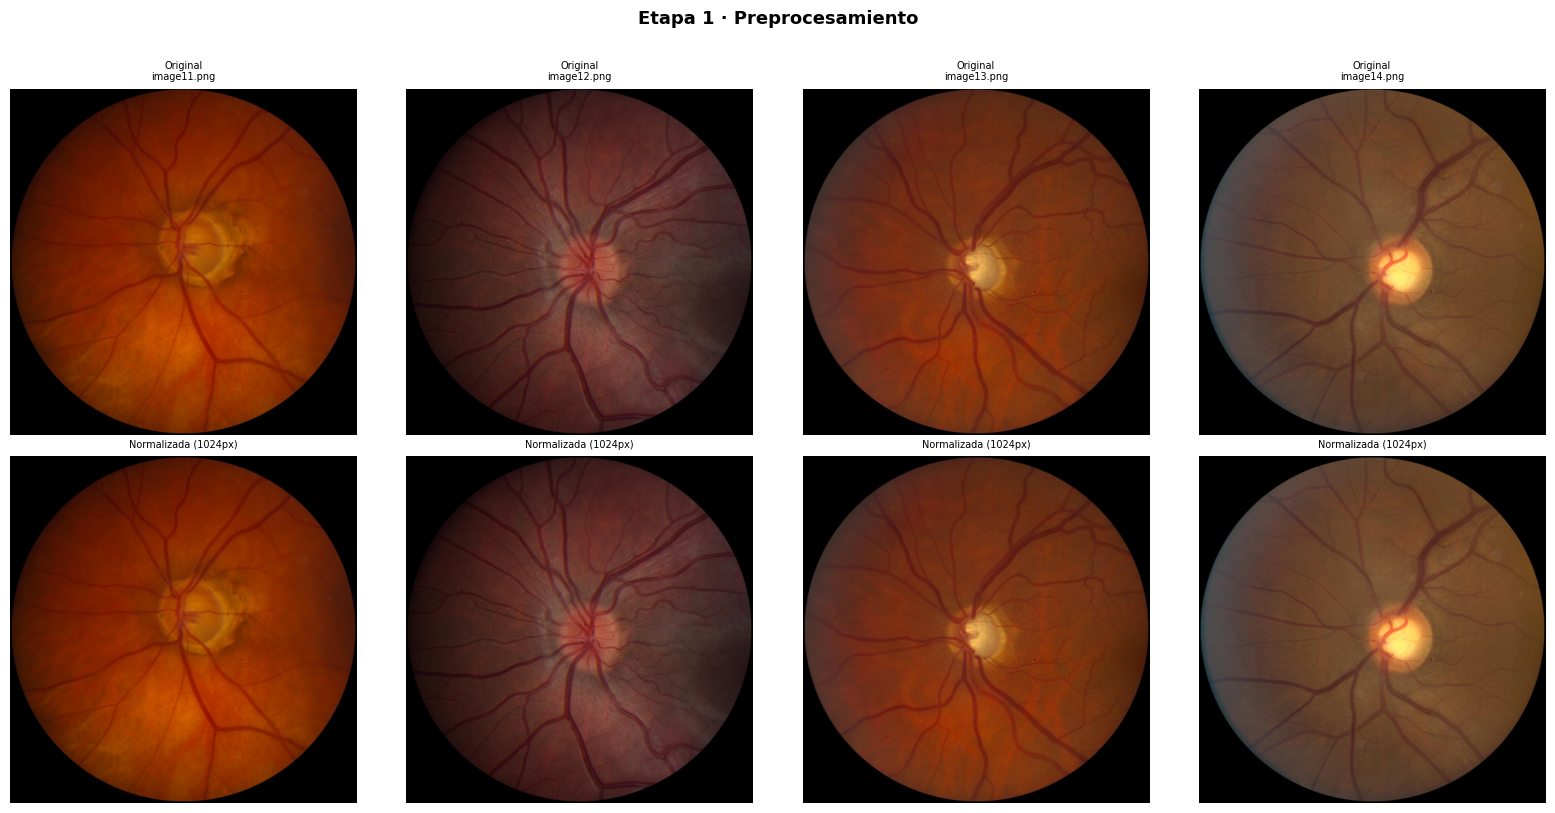

In [ ]:
image_paths = sorted([
    p
    for ext in ("*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff")
    for p in IMAGES_DIR.glob(ext)
])

print(f"Imágenes encontradas: {len(image_paths)}")
if not image_paths:
    print(f"\nColoca las imágenes de fondo de ojo en: {IMAGES_DIR}")

n = min(4, len(image_paths))
if n == 0:
    print("Sin imágenes para mostrar.")
else:
    fig, axes = plt.subplots(2, n, figsize=(4 * n, 8))
    if n == 1:
        axes = axes.reshape(2, 1)

    for i, path in enumerate(image_paths[:n]):
        img_orig    = Image.open(path).convert("RGB")
        img_resized = img_orig.resize((IMAGE_SIZE, IMAGE_SIZE), Image.BILINEAR)
        img_norm    = np.array(img_resized, dtype=np.float32) / 255.0

        axes[0, i].imshow(img_orig)
        axes[0, i].set_title(f"Original\n{path.name}", fontsize=7)
        axes[0, i].axis("off")

        axes[1, i].imshow(img_norm)
        axes[1, i].set_title(f"Normalizada ({IMAGE_SIZE}px)", fontsize=7)
        axes[1, i].axis("off")

    plt.suptitle("Etapa 1 · Preprocesamiento", fontsize=13, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.show()

---
## Etapa 2 — Segmentación vascular (LUNet)
Genera máscaras de arterias, venas y vasos totales.
Salida: `data/artery/`, `data/veins/`, `data/vessels/`.

In [ ]:
path = Path(MODEL_PY)
if not path.exists():
    raise FileNotFoundError(f"No existe: {path}")

ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
backup = path.with_suffix(f".py.bak_{ts}")
shutil.copy2(path, backup)
print("Backup:", backup)

txt = path.read_text(encoding="utf-8")

pattern = r"tf\.maximum\(\s*x\[:,\s*:\s*,\s*:\s*,\s*:1\]\s*,\s*x\[:,\s*:\s*,\s*:\s*,\s*1:\]\s*\)"
replacement = "tf.keras.layers.Maximum()([x[:, :, :, :1], x[:, :, :, 1:]])"

new_txt, n = re.subn(pattern, replacement, txt)
print("Reemplazos encontrados:", n)

if n == 0:
    print("No se encontró tf.maximum(...) con ese patrón (quizá ya está parcheado o cambió el formato).")
else:
    path.write_text(new_txt, encoding="utf-8")
    print("✅ Parche aplicado:", path)

chk = path.read_text(encoding="utf-8")
print("Queda tf.maximum?:", "tf.maximum" in chk)
print("Queda Maximum()?:", "Maximum()" in chk)

import importlib
import LUNet.src.lunet.model as lunet_model
importlib.reload(lunet_model)

_inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_fundus")

model, _attn, _btlnk = build_lunet(
    _inputs,
    init_n_filters=18,
    kernel_size=7,
    transpose_stride=2,
    stride=1,
    keep_prob=1.0,
    block_size=7,
    with_batch_normalization=True,
    scale=True,
    dropblock=False,
    n_layer_output=2,
)

if not WEIGHTS_PATH.exists():
    raise FileNotFoundError(f"No se encontraron los pesos: {WEIGHTS_PATH}")

model.load_weights(str(WEIGHTS_PATH))
print(f"Modelo listo — {len(model.layers)} capas | pesos: {WEIGHTS_PATH.name}")

for img_path in tqdm(image_paths, desc="Etapa 2 · Segmentando"):
    img   = Image.open(img_path).convert("RGB")
    img_r = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.BILINEAR)
    x     = np.expand_dims(np.array(img_r, dtype=np.float32) / 255.0, axis=0)

    y_pred = model(x, training=False).numpy()[0]
    prob   = tf.sigmoid(y_pred).numpy()   # sigmoid explícito, no duplicado
    n_ch   = prob.shape[-1]

    artery = (prob[..., 0] > THRESHOLD).astype(np.uint8) * 255
    vein   = (prob[..., 1] > THRESHOLD).astype(np.uint8) * 255 if n_ch >= 2 else None

    if n_ch >= 3:
        vessel = (prob[..., 2] > THRESHOLD).astype(np.uint8) * 255
    elif vein is not None:
        vessel = ((artery > 0) | (vein > 0)).astype(np.uint8) * 255
    else:
        vessel = artery.copy()

    stem = img_path.stem
    Image.fromarray(artery).save(ARTERY_DIR / f"{stem}.png")
    if vein is not None:
        Image.fromarray(vein).save(VEIN_DIR / f"{stem}.png")
    Image.fromarray(vessel).save(VESSEL_DIR / f"{stem}.png")

print(f"\nMáscaras guardadas en: {ARTERY_DIR.parent}")

_mask_paths = sorted(ARTERY_DIR.glob("*.png"))
n = min(3, len(_mask_paths))

if n == 0:
    print("Sin máscaras para mostrar.")
else:
    fig, axes = plt.subplots(4, n, figsize=(4 * n, 16))
    if n == 1:
        axes = axes.reshape(4, 1)

    for i, artery_path in enumerate(_mask_paths[:n]):
        stem      = artery_path.stem
        orig_path = find_original(stem)
        orig_img  = np.array(
            Image.open(orig_path).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
            if orig_path else Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE))
        )
        artery_mask = np.array(Image.open(artery_path))
        vein_p      = VEIN_DIR / f"{stem}.png"
        vein_mask   = np.array(Image.open(vein_p)) if vein_p.exists() else np.zeros_like(artery_mask)

        # Overlay: rojo = arterias, azul = venas
        overlay = orig_img.copy()
        overlay[artery_mask > 0] = [220, 50, 50]
        overlay[vein_mask   > 0] = [50, 100, 220]

        axes[0, i].imshow(orig_img);    axes[0, i].set_title(f"Original\n{stem}", fontsize=7)
        axes[1, i].imshow(artery_mask, cmap="Reds");  axes[1, i].set_title("Arterias", fontsize=7)
        axes[2, i].imshow(vein_mask,   cmap="Blues"); axes[2, i].set_title("Venas", fontsize=7)
        axes[3, i].imshow(overlay);    axes[3, i].set_title("Overlay (rojo=art, azul=ven)", fontsize=7)

        for ax in axes[:, i]: ax.axis("off")

    plt.suptitle("Etapa 2 · Segmentación vascular", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.show()

---
## Etapa 3 — Extracción de características vasculares (PVBM)
Calcula disco óptico, ROI, zonas ABC, CRAE, CRVE, AVR, tortuosidad y ángulos de ramificación.
- Visualizaciones → `visualizations/`
- Biomarcadores   → `results/biomarcadores.csv`

In [ ]:
segmenter       = DiscSegmenter()
geometricalVBMs = GeometricalVBMs()
creVBMs         = CREVBMs()
print("Módulos PVBM inicializados.")

resultados = []

for seg_path in tqdm(sorted(ARTERY_DIR.glob("*.png")), desc="Etapa 3 · Extrayendo características"):
    stem = seg_path.stem

    # ── Imagen original ──────────────────────────────────────────────────────
    image_path = find_original(stem)
    if image_path is None:
        print(f"[AVISO] Sin imagen original para '{stem}'", flush=True)
        continue
    image = Image.open(image_path)

    # ── Segmentación de arterias ─────────────────────────────────────────────
    segmentation = np.array(Image.open(seg_path)) / 255.0
    if segmentation.ndim == 3:
        segmentation = segmentation[..., 0]
    target_hw = segmentation.shape[:2]
    skeleton  = skeletonize(segmentation > 0.5) * 1

    # 1. Visualizaciones globales
    plt.figure(); plt.imshow(segmentation, cmap="gray"); plt.axis("off")
    save_fig(VIZ_DIRS["segmentation"] / f"{stem}.png")

    plt.figure(); show_image_background(image)
    save_fig(VIZ_DIRS["original"] / f"{stem}.png")

    plt.figure(); plt.imshow(skeleton, cmap="gray"); plt.axis("off")
    save_fig(VIZ_DIRS["skeleton"] / f"{stem}.png")

    # 2. Disco óptico
    optic_disc_np = center_pad_or_crop(
        np.array(segmenter.segment(image_path=str(image_path))), target_hw, pad_value=0
    ).astype(np.uint8)
    optic_disc = Image.fromarray(optic_disc_np)
    plt.figure(); plt.imshow(optic_disc); plt.axis("off")
    save_fig(VIZ_DIRS["optic_disc"] / f"{stem}.png")

    # 3. ROI y zonas ABC
    center, radius, roi, zones_ABC = segmenter.post_processing(
        segmentation=optic_disc, max_roi_size=MAX_ROI_SIZE,
    )
    disc_diameter_px = 2 * radius
    um_per_px = OD_DIAMETER_UM / disc_diameter_px if disc_diameter_px > 0 else np.nan

    plt.figure(); show_image_background(image); overlay_mask(roi, alpha=0.3)
    save_fig(VIZ_DIRS["roi_geom"] / f"{stem}.png")

    plt.figure(); show_image_background(image); overlay_mask(zones_ABC / 255.0, alpha=0.5)
    save_fig(VIZ_DIRS["zones_ABC"] / f"{stem}.png")

    # 4. Biomarcadores geométricos
    segmentation_roi, skeleton_roi = geometricalVBMs.apply_roi(
        segmentation=segmentation, skeleton=skeleton, zones_ABC=zones_ABC, roi=roi,
    )

    plt.figure(); show_image_background(image)
    overlay_mask(segmentation_roi, alpha=0.5); overlay_mask(roi, alpha=0.2)
    save_fig(VIZ_DIRS["roi_segmentation"] / f"{stem}.png")

    plt.figure(); show_image_background(image)
    overlay_mask(skeleton_roi, alpha=0.5); overlay_mask(roi, alpha=0.2)
    save_fig(VIZ_DIRS["roi_skeleton"] / f"{stem}.png")

    geom_vbms, visual = geometricalVBMs.compute_geomVBMs(
        blood_vessel=segmentation_roi, skeleton=skeleton_roi,
        xc=center[0], yc=center[1], radius=radius,
    )
    area, TI, medTor, ovlen, medianba, startp, endp, interp = geom_vbms
    endpoints, interpoints, startpoints, angles_dico, topology_dico = visual

    for pts, viz_key, base_mask in [
        (endpoints,   "endpoints",   segmentation / 50.0),
        (interpoints, "interpoints", segmentation / 20.0),
        (startpoints, "startpoints", segmentation / 20.0),
    ]:
        plt.figure(); show_image_background(image)
        overlay_mask(segmentation_roi, alpha=0.5); overlay_mask(roi, alpha=0.2)
        overlay_mask(base_mask + dilation(pts, square(15)), alpha=0.5)
        save_fig(VIZ_DIRS[viz_key] / f"{stem}.png")

    plt.figure(); show_image_background(image)
    overlay_mask(segmentation_roi, alpha=0.5); overlay_mask(roi, alpha=0.2)
    overlay_mask(build_branching_angle_overlay(angles_dico, segmentation.shape), alpha=0.3)
    save_fig(VIZ_DIRS["angles"] / f"{stem}.png")

    plt.figure(); show_image_background(image)
    overlay_mask(segmentation_roi, alpha=0.5); overlay_mask(roi, alpha=0.2)
    overlay_mask(build_topology_overlay(topology_dico, segmentation.shape), alpha=0.3)
    save_fig(VIZ_DIRS["topology"] / f"{stem}.png")

    # 5. CRAE (arterias)
    seg_roi_cre, skel_roi_cre = creVBMs.apply_roi(
        segmentation=segmentation, skeleton=skeleton, zones_ABC=zones_ABC,
    )
    plt.figure(); overlay_mask(seg_roi_cre, alpha=0.8, cmap="gray")
    overlay_mask(zones_ABC / 255.0, alpha=0.5); plt.axis("off")
    save_fig(VIZ_DIRS["roi_cre"] / f"{stem}.png")

    out_artery = creVBMs.compute_central_retinal_equivalents(
        blood_vessel=seg_roi_cre.copy(), skeleton=skel_roi_cre.copy(),
        xc=center[0], yc=center[1], radius=radius, artery=True, Toplot=PLOT_CRE,
    )
    if out_artery == -1:
        craek = craeh = np.nan
    else:
        cre_art, visualisation = out_artery
        craek = cre_art.get("craek", np.nan)
        craeh = cre_art.get("craeh", np.nan)

        if PLOT_CRE and isinstance(visualisation, list) and visualisation:
            measurements = [item["plot"] for item in visualisation if isinstance(item, dict) and "plot" in item]
            if measurements:
                plt.figure(); show_image_background(image)
                overlay_mask(seg_roi_cre, alpha=0.3)
                overlay_mask(zones_ABC / 255.0, alpha=0.5)
                overlay_mask(np.maximum.reduce(measurements), alpha=0.6)
                sp_cre = np.zeros(seg_roi_cre.shape, dtype=float)
                for item in visualisation:
                    if not isinstance(item, dict): continue
                    if "start" in item: sp_cre[item["start"]] = 1
                    if "end" in item and "Median diameter" in item:
                        plt.annotate(f'{item["Median diameter"]:.2f}',
                                     (item["end"][1], item["end"][0]), color="white", fontsize=8)
                overlay_mask(dilation(sp_cre, square(15)), alpha=0.5)
                plt.axis("off")
                save_fig(VIZ_DIRS["diameters"] / f"{stem}.png")

    # 6. CRVE (venas) — guardia para retorno -1
    crvek = crveh = np.nan
    vein_mask_path = VEIN_DIR / f"{stem}.png"
    if not vein_mask_path.exists():
        print(f"[AVISO] Sin máscara de venas para '{stem}'", flush=True)
    else:
        seg_vein = np.array(Image.open(vein_mask_path))
        if seg_vein.ndim == 3:
            seg_vein = seg_vein[..., 0]
        seg_vein  = (seg_vein > 127).astype(np.uint8)
        skel_vein = skeletonize(seg_vein > 0) * 1

        seg_roi_v, skel_roi_v = creVBMs.apply_roi(
            segmentation=seg_vein, skeleton=skel_vein, zones_ABC=zones_ABC,
        )
        out_vein = creVBMs.compute_central_retinal_equivalents(
            blood_vessel=seg_roi_v.copy(), skeleton=skel_roi_v.copy(),
            xc=center[0], yc=center[1], radius=radius, artery=False, Toplot=False,
        )
        # FIX: verificar retorno -1 antes de desempacar
        if out_vein == -1:
            print(f"[AVISO] CRVE falló para '{stem}'", flush=True)
        else:
            cre_vein, _ = out_vein
            crvek = cre_vein.get("crvek", np.nan)
            crveh = cre_vein.get("crveh", np.nan)
            if crvek == -1: crvek = crveh = np.nan

    # 7. Conversión a micrómetros
    if np.isfinite(um_per_px):
        craek_um = craek * um_per_px
        crvek_um = crvek * um_per_px
        area_um2 = area  * (um_per_px ** 2)
    else:
        craek_um = crvek_um = area_um2 = np.nan

    avr = craek / crvek if (np.isfinite(craek) and np.isfinite(crvek) and crvek > 0) else np.nan

    resultados.append({
        "imagen":            stem,
        "craek":             craek,
        "crvek":             crvek,
        "craek_um":          craek_um,
        "crvek_um":          crvek_um,
        "avr_knudtson":      avr,
        "area_px":           area,
        "area_um2":          area_um2,
        "TI":                TI,
        "median_tortuosity": medTor,
        "disc_diameter_px":  disc_diameter_px,
        "um_per_px":         um_per_px,
    })
    print(
        f"  {stem}: CRAE={craek_um:.1f}µm  CRVE={crvek_um:.1f}µm"
        f"  AVR={avr:.3f}  Tort={medTor:.3f}",
        flush=True,
    )
    
df_bio = pd.DataFrame(resultados)
df_bio.to_csv(BIOMARKERS_CSV, index=False)
print(f"CSV guardado: {BIOMARKERS_CSV}")
df_bio

if df_bio.empty:
    print("Sin biomarcadores para visualizar.")
else:
    _vars   = ["craek_um", "crvek_um", "avr_knudtson", "median_tortuosity"]
    _labels = ["CRAE (µm)", "CRVE (µm)", "AVR", "Tortuosidad mediana"]
    _colors = ["#E06C75", "#61AFEF", "#98C379", "#E5C07B"]

    fig, axes = plt.subplots(1, len(_vars), figsize=(5 * len(_vars), 4))
    for ax, var, lbl, col in zip(axes, _vars, _labels, _colors):
        vals = df_bio[["imagen", var]].dropna(subset=[var])
        if vals.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center", transform=ax.transAxes)
        else:
            ax.bar(vals["imagen"], vals[var], color=col, edgecolor="white")
            ax.tick_params(axis="x", rotation=45, labelsize=7)
        ax.set_title(lbl, fontsize=10)
        ax.set_xlabel("")

    plt.suptitle("Etapa 3 · Biomarcadores vasculares", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.show()

Model path: /content/drive/MyDrive/pipeline/extraccion/PVBM/lunetv2_odc.onnx


Downloading...
From (original): https://drive.google.com/uc?id=116EEFBn7qr_LpCBb8GBuyzpa_KGp4xPX
From (redirected): https://drive.google.com/uc?id=116EEFBn7qr_LpCBb8GBuyzpa_KGp4xPX&confirm=t&uuid=bbb4f03c-984a-4bbb-b310-cb1b65a57dd6
To: /content/drive/MyDrive/pipeline/extraccion/PVBM/lunetv2_odc.onnx
100%|██████████| 125M/125M [00:03<00:00, 34.6MB/s]

Model downloaded to /content/drive/MyDrive/pipeline/extraccion/PVBM/lunetv2_odc.onnx
Módulos PVBM inicializados.


---
## Etapa 4 — Árbol de proximidad difusa
Clasifica cada imagen con las 5 reglas clínicas usando puntajes de cercanía (score gaussiano por variable).
Salida: `results/clasificacion.csv`.

In [ ]:
clasificar_desde_csv(BIOMARKERS_CSV, CLASSIFICATION_CSV)

df_cls = pd.read_csv(CLASSIFICATION_CSV)

# ── Tabla resumen ─────────────────────────────────────────────────────────────
_cols = ["imagen", "crae_um", "crve_um", "avr", "tortuosidad", "clasificacion"]
print("=== Clasificación por imagen ===")
print(df_cls[_cols].to_string(index=False))

# ── Gráfico de barras apiladas ────────────────────────────────────────────────
if not df_cls.empty:
    _pct_cols = ["pct_sano", "pct_sospecha_rh", "pct_alto_riesgo_rh", "pct_sospecha_rd", "pct_alto_riesgo_rd"]
    _leg      = ["Sano", "Sospecha RH", "Alto riesgo RH", "Sospecha RD", "Alto riesgo RD"]
    _colors   = ["#2ecc71", "#f39c12", "#e74c3c", "#3498db", "#9b59b6"]

    df_plot = df_cls.set_index("imagen")[_pct_cols]
    ax = df_plot.plot(
        kind="bar", stacked=True, color=_colors,
        figsize=(max(8, len(df_cls) * 2), 5), width=0.65,
    )
    ax.set_ylabel("Porcentaje (%)")
    ax.set_ylim(0, 115)
    ax.legend(_leg, bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=9)
    ax.tick_params(axis="x", rotation=45, labelsize=8)

    # Etiqueta de la clase dominante sobre cada barra
    for idx, (_, row) in enumerate(df_cls.iterrows()):
        pcts = row[_pct_cols].values
        best = _leg[int(pcts.argmax())]
        ax.text(idx, 102, best, ha="center", va="bottom", fontsize=7, rotation=30)

    plt.title("Etapa 4 · Árbol de proximidad difusa", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.show()

Clasificación guardada: /content/drive/MyDrive/pipeline/results/clasificacion.csv
